# Лабораторная лабора №1


## 1.	Выбор начальных условий

#### Импорты и библиотеки

In [ ]:
!pip install nltk
!pip install tokenizers
!pip install pymystem3

In [61]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import torch

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

from pymystem3 import Mystem
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.preprocessing import LabelEncoder


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Данные для классификации

In [63]:
df = pd.read_excel("/content/drive/MyDrive/ai_course/dataset.xlsx")
df.to_csv("dataset.csv", index = False)
df

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport
...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis
53196,776944963,Стал известен календарь мужской сборной России...,volleyball


Для задачи классификации я выбрала текстовый датасет, так как работаю с обработкой естественного языка (NLP), и мне интересно применять машинное обучение именно к текстам.
В датасете представлены тексты (отзывы) с разными метками классов.

Также этот набор данных позволяет использовать базовые приёмы предобработки текста — токенизацию, векторизацию, лемматизацию, что делает задачу более интересной

Для оценки качества модели классификации беру стандартные метрики:

- Precision (точность) — показывает, какая доля объектов, предсказанных как положительные, действительно являются положительными.

- Recall (полнота) — показывает, какую долю реальных положительных объектов модель смогла найти.

- F1-score — гармоническое среднее

Эти метрики являются классическими и позволяют полноценно оценить качество модели

### Данные для регрессии

In [64]:
df_reg = pd.read_csv("/content/drive/MyDrive/ai_course/train.csv")
df_reg

,cow_id,milk_yield_kg,feed_energy_eke,feed_crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,milk_fat_pct,milk_protein_pct,milk_taste_label,age_group
0,488,6005,13.5,1842,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.62,3.073,не вкусно,более_2_лет
1,422,5982,13.8,1722,0.890,РефлешнСоверинг,Холмистое,Айдиал,3.61,3.073,не вкусно,более_2_лет
2,105,5700,14.4,1934,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.079,вкусно,более_2_лет
3,115,5412,12.1,1924,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.071,не вкусно,менее_2_лет
4,350,6171,15.3,1966,0.940,РефлешнСоверинг,Равнинное,Соверин,3.73,3.076,вкусно,более_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
502,72,5809,13.5,2093,0.895,РефлешнСоверинг,Равнинные,Айдиалл,3.61,3.079,не вкусно,более_2_лет
503,107,5417,13.2,1848,0.890,Вис Бик Айдиал,Холмистое,Соверин,3.57,3.076,вкусно,менее_2_лет
504,271,6597,14.2,2204,0.950,РефлешнСоверинг,Равнинное,Соверин,3.74,3.079,не вкусно,более_2_лет
505,436,6054,15.7,1859,0.940,РефлешнСоверинг,Холмистое,Соверин,3.71,3.080,вкусно,более_2_лет


##### Описание данных

Каждая строка — отдельная корова.

| Column | Meaning |
| --- | --- |
| `cow_id` | Уникальный идентификатор коровы |
| `milk_yield_kg` | Годовой удой (кг) — целевой признак |
| `feed_energy_eke` | Энергетическая кормовая единица |
| `feed_crude_protein_g` | Содержание сырого протеина в корме (г) |
| `sugar_protein_ratio` | Сахаро-протеиновое соотношение |
| `breed` | Порода коровы |
| `pasture_type` | Тип пастбища |
| `sire_breed` | Порода отца |
| `milk_fat_pct` | Жирность молока (%) |
| `milk_protein_pct` | Белок в молоке (%) |
| `milk_taste_label` | Качественная оценка вкуса |
| `age_group` | Возрастная группа (`under_2_years`, `over_2_years`) |

Для задачи регрессии я выбрала датасет про коров, так как он необычный и содержит как числовые, так и категориальные признаки.

История задачи: фермерское хозяйство планирует расширить стадо и просит нас построить модель, которая по характеристикам коровы и рациона будет предсказывать годовой удой `milk_yield_kg`

Интерес в том, что такие данные требуют внимательного подхода к обработке категориальных признаков, нормализации и анализу корреляций.

Основная метрика:

- MAE - так как это максимально интуитивно понятная метрика, насколько в среднем предсказания модели отличаются от реальных значений

Дополнительные метрики:

- RMSE — более чувствительная к выбросам

- R^2 — показывает, насколько хорошо модель объясняет разброс данных

## 2. Создание бейзлайна и оценка качества

### Бейзлайн классификация

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53198 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       53198 non-null  int64 
 1   text      53198 non-null  object
 2   category  53198 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
RANDOM_STATE = 42

TEXT_COL = "text"
LABEL_COL = "category"

In [16]:
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
df

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport
...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis
53196,776944963,Стал известен календарь мужской сборной России...,volleyball


In [17]:
le = LabelEncoder()
y = le.fit_transform(df[LABEL_COL].astype(str))
X = df[TEXT_COL].astype(str)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Модель бейзлайна: TF-IDF ля разреженного представления текста и перевод в вектор -> KNN

In [20]:
classification = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        max_features=80_000,
        sublinear_tf=True,
        norm="l2"
    )),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",
        metric="euclidean",
        n_jobs=-1
    ))
])

In [21]:
classification.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=80000, min_df=2,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('knn', KNeighborsClassifier(metric='euclidean', n_jobs=-1))])

In [ ]:
y_pred = classification.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   athletics       0.72      0.86      0.79       957
   autosport       0.68      0.74      0.71       630
  basketball       0.73      0.82      0.77       866
  boardgames       0.88      0.91      0.89       910
      esport       0.64      0.73      0.68       902
     extreme       0.69      0.55      0.61       634
    football       0.66      0.67      0.66       852
      hockey       0.77      0.54      0.64       370
martial_arts       0.79      0.68      0.73       852
   motosport       0.83      0.85      0.84       906
      tennis       0.92      0.90      0.91       917
  volleyball       0.82      0.74      0.78       937
winter_sport       0.83      0.76      0.79       907

    accuracy                           0.77     10640
   macro avg       0.77      0.75      0.75     10640
weighted avg       0.77      0.77      0.77     10640



In [24]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df

,athletics,autosport,basketball,boardgames,esport,extreme,football,hockey,martial_arts,motosport,tennis,volleyball,winter_sport
athletics,826,9,13,14,22,14,11,0,11,7,3,13,14
autosport,24,468,22,10,21,13,15,1,10,19,8,8,11
basketball,20,8,712,7,31,8,30,9,6,5,5,17,8
boardgames,13,14,13,830,11,2,4,0,3,11,1,3,5
esport,41,32,39,22,656,19,28,5,13,14,5,20,8
extreme,44,27,18,23,55,348,17,3,27,35,5,16,16
football,28,28,41,10,60,18,567,15,23,20,8,20,14
hockey,9,14,19,5,17,2,57,201,5,7,5,13,16
martial_arts,37,28,31,10,43,32,33,5,580,11,12,14,16
motosport,22,29,7,2,29,14,9,2,7,770,2,7,6


#### Выводы по бейзлайну

Результат Weighted F1 = 0.77

Большой разброс по классам:
- сильные: tennis (f1 ~ 0.91), boardgames (~ 0.89)...
- слабые: extreme (~ 0.61), hockey (~ 0.64)...

Явно виден дисбаланс: на классах с маленьким support качество сильно хуже

В целом результат не ужасный, но нужно быть осторожными с узкими местами - похожими классами и дисбаллансом + попробовать настроить параметры

### Бейзлайн регрессия

In [25]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [47]:
train = pd.read_csv("/content/drive/MyDrive/ai_course/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ai_course/test.csv")
train.head()

,cow_id,milk_yield_kg,feed_energy_eke,feed_crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,milk_fat_pct,milk_protein_pct,milk_taste_label,age_group
0,488,6005,13.5,1842,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.62,3.073,не вкусно,более_2_лет
1,422,5982,13.8,1722,0.890,РефлешнСоверинг,Холмистое,Айдиал,3.61,3.073,не вкусно,более_2_лет
2,105,5700,14.4,1934,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.079,вкусно,более_2_лет
3,115,5412,12.1,1924,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.071,не вкусно,менее_2_лет
4,350,6171,15.3,1966,0.940,РефлешнСоверинг,Равнинное,Соверин,3.73,3.076,вкусно,более_2_лет


In [45]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cow_id                507 non-null    int64  
 1   milk_yield_kg         507 non-null    int64  
 2   feed_energy_eke       507 non-null    float64
 3   feed_crude_protein_g  507 non-null    int64  
 4   sugar_protein_ratio   507 non-null    float64
 5   breed                 507 non-null    object 
 6   pasture_type          507 non-null    object 
 7   sire_breed            507 non-null    object 
 8   milk_fat_pct          507 non-null    float64
 9   milk_protein_pct      507 non-null    float64
 10  milk_taste_label      507 non-null    object 
 11  age_group             507 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 47.7+ KB


In [48]:
TARGET_COL = "milk_yield_kg"
ID_COL_CANDIDATES = ["cow_id"]

In [49]:
feature_cols = [c for c in train.columns if c != TARGET_COL]

id_col = next((c for c in ID_COL_CANDIDATES if c in test.columns), None)
if id_col is None:
    test_id = pd.Series(test.index, name="row_id")
else:
    test_id = test[id_col].copy()

In [50]:
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(train[c])]
cat_cols = [c for c in feature_cols if c not in num_cols]

Минимальные препроцессинг данных для работы модели

In [51]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

In [52]:
reg = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsRegressor(
        n_neighbors=5,
        weights="uniform",
        metric="minkowski",
        p=2,
        n_jobs=-1
    ))
])

In [54]:
X = train[feature_cols]
y = train[TARGET_COL].astype(float)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [56]:
reg.fit(X_tr, y_tr)
y_hat = reg.predict(X_te)

mae  = mean_absolute_error(y_te, y_hat)
mse = mean_squared_error(y_te, y_hat)
r2 = r2_score(y_te, y_hat)
print(f"[VALIDATION] MAE : {mae:.4f}")
print(f"[VALIDATION] MSE: {mse:.4f}")
print(f"[VALIDATION] R^2 : {r2:.4f}")

[VALIDATION] MAE : 247.0078
[VALIDATION] MSE: 595820.2086
[VALIDATION] R^2 : -1.2367


#### Выводы по регрессии

MAE = ~ 247 - наша основная метрика, показывает неплохой результат

По NSE видно, что есть выбросы, которые нужно аккуратно обработать

R^2 почему-то отрицательное)))


## 3. Улучшение бейзлайна

### Классификация

####  Подготовка текста

Кратко гипотезы, которые дальше буду раскрывать:
- большой дисбаланс -> smote
- очень грязный текст -> удаление стоп слов и очистка данных
- tfidf может быть слабеньким -> буду брать эмбеддинги
- выбросы, странные данные

In [58]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [65]:
df = pd.read_excel("/content/drive/MyDrive/ai_course/dataset.xlsx")

In [67]:
df.head()

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport


In [66]:
df.to_csv("dataset.csv", index = False)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53198 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       53198 non-null  int64 
 1   text      53198 non-null  object
 2   category  53198 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


#### Количество новостей по каждой категории

In [69]:
class_counts = df.iloc[:, -1].value_counts()

for cls, count in class_counts.items():
    print(f"{cls}: {count}")

athletics: 4782
volleyball: 4683
tennis: 4584
boardgames: 4551
winter_sport: 4536
motosport: 4528
esport: 4509
basketball: 4329
football: 4262
martial_arts: 4259
extreme: 3172
autosport: 3152
hockey: 1851


In [70]:
df.describe()

,oid
count,5.319800e+04
mean,5.070402e+08
std,2.845804e+08
min,1.659400e+04
25%,2.685499e+08
50%,5.117385e+08
75%,7.489505e+08
max,9.997113e+08


#### Балансировка классов

Первым делом удаление дубликатов

In [71]:
duplicates = df[df.duplicated(subset=['text'], keep=False)]
df = df.drop_duplicates(subset=['text'], keep='first')

In [72]:
removed_duplicates = duplicates[~duplicates.index.isin(df.index)].reset_index()
paired_duplicates_with_index = removed_duplicates.merge(df.reset_index(), on='text', how='inner', suffixes=('_removed', '_original'))
paired_duplicates_with_index[['index_removed', 'text', 'index_original']]


,index_removed,text,index_original
0,51,Как играли в баскетбол раньше. . У кого до сих...,49
1,54,До свидания щит 33 Дмитрий Михеев во всей крас...,48
2,519,В Шерегеше 1 июля откроется один из самых боль...,448
3,641,За кроссовками в Баскетбольный магазин Ghetto ...,640
4,642,За кроссовками в Баскетбольный магазин Ghetto ...,640
...,...,...,...
5220,53174,news tokenoid Sttokenoid Hortokenoid В трейлер...,3795
5221,53175,Счастливчики которые уносят Кассадина 33 За пр...,30407
5222,53179,В продаже октябрьский Мир фантастики В этом но...,9817
5223,53182,На нашем сайте появились две новые настолки дл...,15482


In [73]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 47973 entries, 0 to 53197
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       47973 non-null  int64 
 1   text      47973 non-null  object
 2   category  47973 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


(47973, 3)

Мы удалили явные дубликаты, но, возможно, есть те, которые имеют одинаковый текст новости, но при этом различные знаки препинания/регистр

#### Предобработка текста

**Удаление:**
1. знаки препинания
2. числа
3. слова, которые встречаются в каждом классе
4. tokenoid - мусор
5. лишние пробелы
6. лемматизация
7. повторы в одной новости
8. стоп слова и слова длины < 1

In [75]:
stop = set(stopwords.words('russian'))
with open('/content/drive/MyDrive/ai_course/stopwords-ru.txt', 'r', encoding='utf-8') as file:
    additional_stop_words = set(file.read().splitlines())


In [76]:
def preprocess_text(text):
    pattern_punct = r'[^\w\s]'
    text = re.sub(pattern_punct, '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    pattern_digits = r'[+-]?\d+(\.\d+)?'
    text = re.sub(pattern_digits, '', text)
    pattern_tok = r'\b\w*tokenoid\w*\b'
    pattern_common_words = r'\bэто\b|\bгод\b|\bдень\b|\bхороший\b|\bкоторый\b'
    text = re.sub(pattern_tok, '', text)
    text = re.sub(pattern_common_words, '', text)
    return text

df['preprocess_text'] = df['text'].apply(preprocess_text)

In [77]:
df

,oid,text,category,preprocess_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочно сообщество продается за р за покупкой п...
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побудет здесь борьбавпрямомэфире
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюлей от мунсунга борьбавпрямомэфире
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,не знаю как вам но мне стилистика нравится пус...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншоты из новой главы тэхунчика показали и ...
...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,битная буря снова накрыла пикселями автомобил...
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,ира сидоркова объясняет как сказалась на ее ма...
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,я ракетка мира хорват марин чилич обыграл исп...
53196,776944963,Стал известен календарь мужской сборной России...,volleyball,стал известен календарь мужской сборной россии...


In [78]:
# удаление стоп слов
all_stop_words = stop.union(additional_stop_words)
df['preprocess_text'] = df['preprocess_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in all_stop_words and len(word) > 1]))

In [79]:
df.head()

,oid,text,category,preprocess_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочно сообщество продается покупкой пишите лс...
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побудет борьбавпрямомэфире
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюлей мунсунга борьбавпрямомэфире
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знаю стилистика нравится пускай странная борьб...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншоты новой главы тэхунчика показали хобина


#### Объединение терминов

Я заметила, что есть термины, которые часто встречаются и объединила их

In [80]:
def join_english_terms(text):
    terms = {
        "cs go": "csgo",
        "ai": "ai",
        "ml": "ml",
        "nft": "nft",
        "block chain": "blockchain"
    }
    for term, replacement in terms.items():
        text = re.sub(r'\b{}\b'.format(term), replacement, text, flags=re.IGNORECASE)
    return text

In [81]:
df['preprocess_text'] = df['preprocess_text'].apply(join_english_terms)

In [82]:
mystem = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [83]:
def lemmatize_text(text):
    lemmas = mystem.lemmatize(text)
    lemmas = [lemma for lemma in lemmas if lemma.strip() not in stop and lemma.strip()]
    return ' '.join(lemmas)

In [84]:
df['preprocess_text'] = df['preprocess_text'].apply(lemmatize_text)

In [85]:
df['preprocess_text'] = df['preprocess_text'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

Снова удаляю дубликаты новостей, если вдруг они появились после предварительной обработки

Как итог: дубликатов не оказалось

In [86]:
duplicates = df[df.duplicated(subset=['preprocess_text'], keep=False)]
df = df.drop_duplicates(subset=['preprocess_text'], keep='first')
df.shape

(47504, 4)

In [87]:
def count_words(text):
    return len(text.split())

df['word_count'] = df['preprocess_text'].apply(count_words)

total_word_count = df['word_count'].sum()
total_word_count

/tmp/ipython-input-1032766255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['preprocess_text'].apply(count_words)


np.int64(1362444)

In [88]:
df['len_text'] = df['preprocess_text'].apply(len)

/tmp/ipython-input-2363452489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_text'] = df['preprocess_text'].apply(len)


In [89]:
df

,oid,text,category,preprocess_text,word_count,len_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочный сообщество продаваться покупка писать ...,7,57
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть побыть борьбавпрямомэфир,3,30
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюли мунсунг борьбавпрямомэфир,4,41
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знать стилистика нравиться пускай странный бор...,6,60
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншот новый глава тэхунчик показывать хобин,6,46
...,...,...,...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport,битный буря накрывать пиксел автомобиль нуждат...,27,221
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport,ира сидорков объяснять сказываться машина резу...,51,380
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis,ракетка хорват марина чилич обыгрывать испанец...,24,176
53196,776944963,Стал известен календарь мужской сборной России...,volleyball,известный календарь мужской сборная россия роз...,34,264


График, демонстрирующий длины новостей

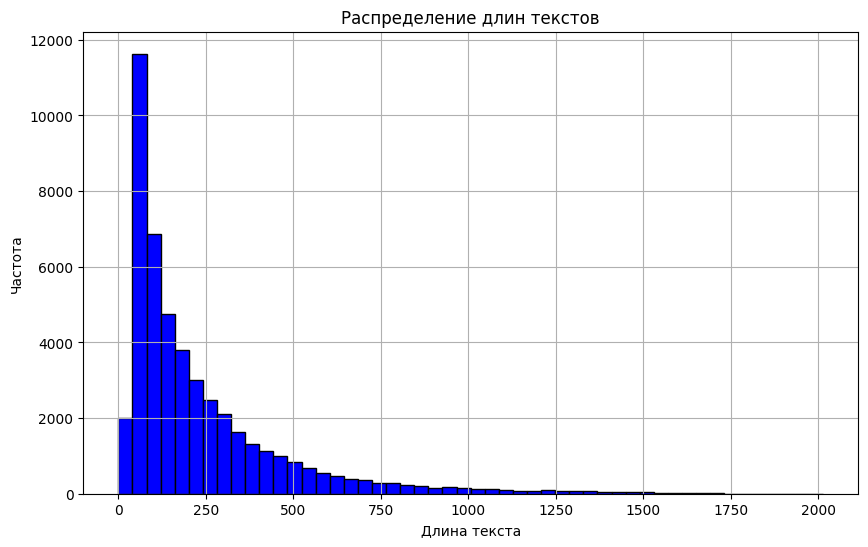

,len_text
count,47504.000000
mean,236.992064
std,248.397830
min,0.000000
25%,73.000000
50%,148.000000
75%,303.000000
max,2013.000000


In [90]:
length_stats = df['len_text'].describe()

plt.figure(figsize=(10, 6))
plt.hist(df['len_text'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

length_stats

In [91]:
df['oid'].nunique()

5971

#### Объединение новостей одного oid

Объединяла тексты новостей одинакового id по определеному порогу для уменьшения датасета.

```thresholds``` - порог длины текста, который я подбирала, чтобы количество новостей по категории было +- одинаковое

Первоначально сделала один порог и обучала на таком датасете, но после преобразования порога результаты получились чуть лучше



In [92]:
thresholds = {
    'athletics': 130, 'winter_sport': 130, 'motosport': 110,
    'martial_arts': 100, 'volleyball': 100, 'boardgames': 100,
    'autosport': 85, 'tennis': 90, 'football': 80,
    'basketball': 75, 'extreme': 65,
    'esport': 55, 'hockey': 25
}

def combine_texts(df, thresholds):
    combined_texts = []
    oids = df['oid'].unique()

    for oid in oids:
        category = df[df['oid'] == oid]['category'].values[0]
        threshold = thresholds.get(category, 120)
        oid_texts = df[df['oid'] == oid]['preprocess_text'].tolist()
        combined_text = ''

        for text in oid_texts:
            if len(combined_text.split()) + len(text.split()) <= threshold:
                combined_text = combined_text + ' ' + text
            else:
                if combined_text:
                    combined_texts.append({
                        'oid': oid,
                        'category': category,
                        'preprocess_text': combined_text.strip()
                    })
                combined_text = text

        if combined_text:
            combined_texts.append({
                'oid': oid,
                'category': category,
                'preprocess_text': combined_text.strip()
            })

    return pd.DataFrame(combined_texts)

In [93]:
df_final = combine_texts(df, thresholds)

In [94]:
df_final

,oid,category,preprocess_text
0,749208109,esport,спочный сообщество продаваться покупка писать ...
1,452466036,martial_arts,естественный восстановление тяжелый тренировка...
2,452466036,martial_arts,владимир путин ислам махачев звонить хотеть по...
3,452466036,martial_arts,абдулманап нурмагомедов прошлый весна доводить...
4,452466036,martial_arts,джастин гэтжи уверенный бой чарльз оливейра аз...
...,...,...,...
20029,747121187,boardgames,гильдияразработчиковнастольныхигра грань полез...
20030,881882347,boardgames,привет грань дискуссия хотеть обсуждать интере...
20031,209435461,esport,аудио визуальный вкус красота нотка возбуждени...
20032,922932190,hockey,сборная россия сыграть финляндия финал олимпиа...


In [95]:
output_path = 'final_dataset.csv'
df_final.to_csv(output_path, index=False)

In [96]:
df_final['len_text'] = df_final['preprocess_text'].apply(len)

проверяла количество слов, чтобы удостовериться в том, что никакие новости не были потеряны

In [97]:
def count_words(text):
    return len(text.split())

df_final['word_count'] = df_final['preprocess_text'].apply(count_words)

total_word_count = df_final['word_count'].sum()
total_word_count

np.int64(1362444)

График длин новостей на новых данных

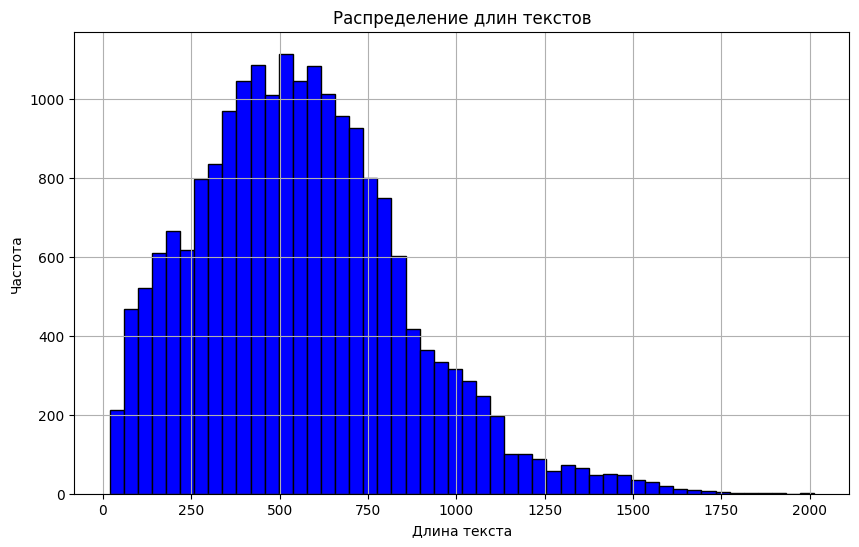

,len_text
count,20034.000000
mean,563.319407
std,295.727053
min,19.000000
25%,350.000000
50%,540.000000
75%,739.000000
max,2013.000000


In [98]:
length_stats = df_final['len_text'].describe()

plt.figure(figsize=(10, 6))
plt.hist(df_final['len_text'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

length_stats

Можно заметить выброс справа -> удалю его

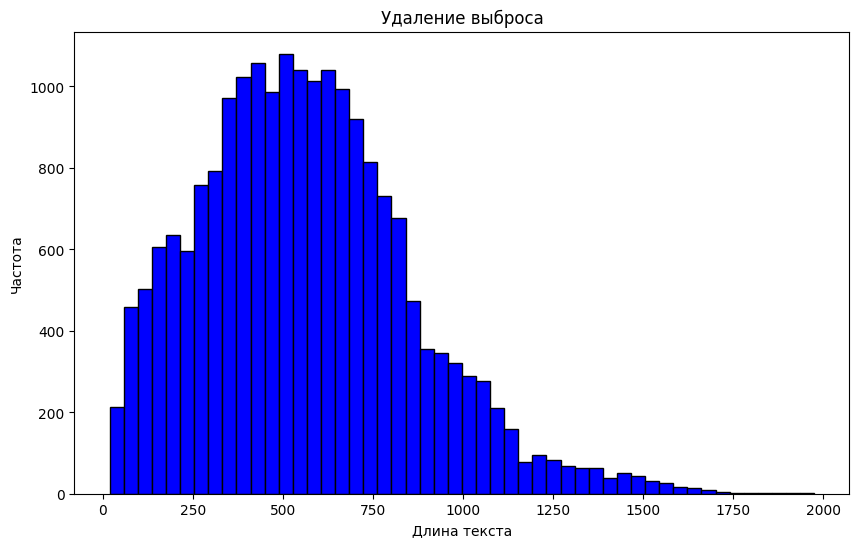

(         oid      category                                    preprocess_text  \
 0  749208109        esport  спочный сообщество продаваться покупка писать ...   
 1  452466036  martial_arts  естественный восстановление тяжелый тренировка...   
 2  452466036  martial_arts  владимир путин ислам махачев звонить хотеть по...   
 3  452466036  martial_arts  абдулманап нурмагомедов прошлый весна доводить...   
 4  452466036  martial_arts  джастин гэтжи уверенный бой чарльз оливейра аз...   
 
    len_text  word_count  
 0       414          47  
 1       687          85  
 2       541          65  
 3       834          98  
 4       274          34  ,
 (20033, 5))

In [99]:
threshold_length = 2000
df_final = df_final[df_final['len_text'] <= threshold_length]

plt.figure(figsize=(10, 6))
plt.hist(df_final['len_text'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Удаление выброса')
plt.show()

df_final.head(), df_final.shape

In [100]:
df_final = df_final.drop(columns = ['word_count'])

#### Итоговое количество новостей по каждой категории

In [101]:
class_counts = df_final['category'].value_counts()

for cls, count in class_counts.items():
    print(f"{cls}: {count}")

tennis: 1585
volleyball: 1582
esport: 1570
martial_arts: 1567
athletics: 1555
basketball: 1534
football: 1533
extreme: 1531
boardgames: 1524
winter_sport: 1523
motosport: 1516
autosport: 1509
hockey: 1504


In [102]:
from imblearn.over_sampling import SMOTE

In [103]:
X = df_final['preprocess_text']
y = df_final['category']


In [104]:
# кодирование категориального признака ДЛЯ ЛСТМ
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#### Разделение выборки на тестовую и обучающую

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [106]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (16026,)
Размер тестовой выборки: (4007,)


In [107]:
from transformers import AutoTokenizer, AutoModel

#### Эмбеддинги RuBert

В бейзлайне видно, что модель путает близуие спорт, поэтому использую эмбеддинги, которые отражают "смысл" текста, то есть учитывают семантику

In [108]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/716M [00:00<?, ?B/s]

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(120138, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [110]:
def get_bert_embeddings_batch(texts, tokenizer, model, batch_size=32):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [111]:
X_train_embeddings = get_bert_embeddings_batch(X_train.tolist(), tokenizer, model)

In [112]:
X_test_embeddings = get_bert_embeddings_batch(X_test.tolist(), tokenizer, model)

In [113]:
embeddings_df = pd.DataFrame(X_train_embeddings)
embeddings_df['category'] = y_train

In [114]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [115]:
tsne = TSNE(n_components=2, random_state=42)
X_train_embeddings_2d = tsne.fit_transform(X_train_embeddings)

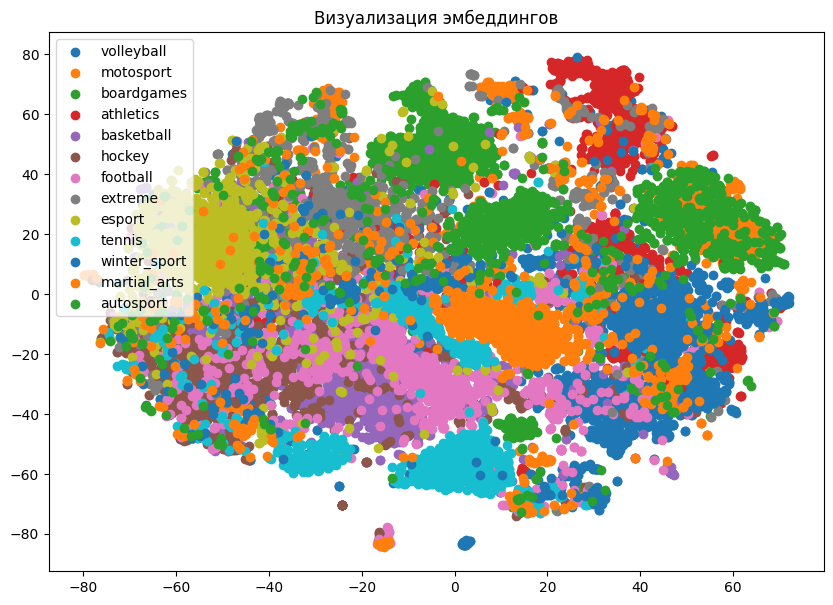

In [116]:
vis_df = pd.DataFrame(X_train_embeddings_2d, columns=['x', 'y'])
vis_df['category'] = label_encoder.inverse_transform(y_train)

plt.figure(figsize=(10, 7))
for category in vis_df['category'].unique():
    subset = vis_df[vis_df['category'] == category]
    plt.scatter(subset['x'], subset['y'], label=category)
plt.legend()
plt.title('Визуализация эмбеддингов')
plt.show()

результат неплохой, видно облака каждого класса

#### Наконец обучение модели

- добавлю smote, которая создает синтетические образцы для меньшенств
- для оптимальных гиперпараметров буду брать gridsearch, чтобы перебрать соседей и тип усреднения весов (distance дает больший вес ближайших соседям - это должно быть хорошо, если нечеткие границы классов)
- за основную метрику возьму f1_macro, т.к. она одинаково учитывает все классы, даже редкие

Ожидаю, что очистка и эмбеддинги сильно улучшат качество за счет смысловой информаци, балансировка должна сильно помочь + оптимизация

In [117]:
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [119]:
RANDOM_STATE = 42

pipe_cls = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("norm", Normalizer(norm="l2")),
    ("knn", KNeighborsClassifier(n_jobs=-1))
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean"]
}

In [120]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [121]:
search = GridSearchCV(
    pipe_cls,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_embeddings, y_train)
print("Best params:", search.best_params_)
print("Best CV f1_macro:", round(search.best_score_, 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best CV f1_macro: 0.7826


In [122]:
best_cls = search.best_estimator_
y_pred = best_cls.predict(X_test_embeddings)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       311
           1       0.83      0.61      0.70       302
           2       0.75      0.75      0.75       307
           3       0.88      0.94      0.91       305
           4       0.76      0.78      0.77       314
           5       0.68      0.76      0.72       306
           6       0.85      0.62      0.71       307
           7       0.67      0.80      0.73       301
           8       0.88      0.77      0.82       313
           9       0.74      0.81      0.78       303
          10       0.85      0.91      0.88       317
          11       0.81      0.78      0.80       316
          12       0.73      0.85      0.79       305

    accuracy                           0.79      4007
   macro avg       0.79      0.79      0.78      4007
weighted avg       0.79      0.79      0.79      4007



#### ИТОГ 3 пункта

Было marco f1 ~ 0.75 -> стало ~ 0.77

Произошел прирост метрик - ровный прирост на всех классах
по-прежнему есть очень сильные классы, а есть проседающие

Но СТАЛО ЛУЧШЕ

сохраняю данные, чтобы в других лабах переиспользовать

In [124]:
from pathlib import Path
import numpy as np
from joblib import dump

SAVE_DIR = Path("classification")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

np.save(SAVE_DIR / "X_train_embeddings.npy", X_train_embeddings)
np.save(SAVE_DIR / "X_test_embeddings.npy",  X_test_embeddings)
np.save(SAVE_DIR / "y_train.npy", np.asarray(y_train))
np.save(SAVE_DIR / "y_test.npy", np.asarray(y_test))

### Регрессия

#### Гипотезы

- нужно внимательно посмотреть на качество данных, что с пропусками и выбросами, учитывае mse - они должны быть
- проверить распределеные целевой переменной и почистить
- нужно проверить влияние между признаками

In [162]:
df_reg = pd.read_csv("/content/drive/MyDrive/ai_course/train.csv")
df_reg.head()

,cow_id,milk_yield_kg,feed_energy_eke,feed_crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,milk_fat_pct,milk_protein_pct,milk_taste_label,age_group
0,488,6005,13.5,1842,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.62,3.073,не вкусно,более_2_лет
1,422,5982,13.8,1722,0.890,РефлешнСоверинг,Холмистое,Айдиал,3.61,3.073,не вкусно,более_2_лет
2,105,5700,14.4,1934,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.079,вкусно,более_2_лет
3,115,5412,12.1,1924,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.57,3.071,не вкусно,менее_2_лет
4,350,6171,15.3,1966,0.940,РефлешнСоверинг,Равнинное,Соверин,3.73,3.076,вкусно,более_2_лет


In [163]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cow_id                507 non-null    int64  
 1   milk_yield_kg         507 non-null    int64  
 2   feed_energy_eke       507 non-null    float64
 3   feed_crude_protein_g  507 non-null    int64  
 4   sugar_protein_ratio   507 non-null    float64
 5   breed                 507 non-null    object 
 6   pasture_type          507 non-null    object 
 7   sire_breed            507 non-null    object 
 8   milk_fat_pct          507 non-null    float64
 9   milk_protein_pct      507 non-null    float64
 10  milk_taste_label      507 non-null    object 
 11  age_group             507 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 47.7+ KB


In [164]:
target_name = "milk_yield_kg"
X = df_reg.drop(columns=[target_name])
y = df_reg[target_name]

смотрим на пропуски -> пусто

In [165]:
df_reg.isna().mean().sort_values(ascending=False)

,0
cow_id,0.0
milk_yield_kg,0.0
feed_energy_eke,0.0
feed_crude_protein_g,0.0
sugar_protein_ratio,0.0
breed,0.0
pasture_type,0.0
sire_breed,0.0
milk_fat_pct,0.0
milk_protein_pct,0.0


In [166]:
df_reg.shape

(507, 12)

In [167]:
df_reg.describe().T

,count,mean,std,min,25%,50%,75%,max
cow_id,507.0,319.187377,182.571548,1.000,160.500,320.000,477.500,629.000
milk_yield_kg,507.0,6197.429980,1814.353749,5204.000,5752.500,6130.000,6487.000,45616.000
feed_energy_eke,507.0,14.552268,1.289180,11.100,13.500,14.700,15.600,16.800
feed_crude_protein_g,507.0,1919.360947,180.863546,1660.000,1769.000,1877.000,2051.500,2349.000
sugar_protein_ratio,507.0,0.912604,0.032436,0.840,0.890,0.930,0.940,0.960
milk_fat_pct,507.0,3.603097,0.169784,2.990,3.590,3.640,3.720,3.750
milk_protein_pct,507.0,3.075657,0.002555,3.069,3.074,3.076,3.077,3.085


Явно выдно выброс - 45616.000 при достаточно малом среднем -> нужно будет удалить

Остальные признаки хорошо распределены, без резких аномалий

In [168]:
import seaborn as sns

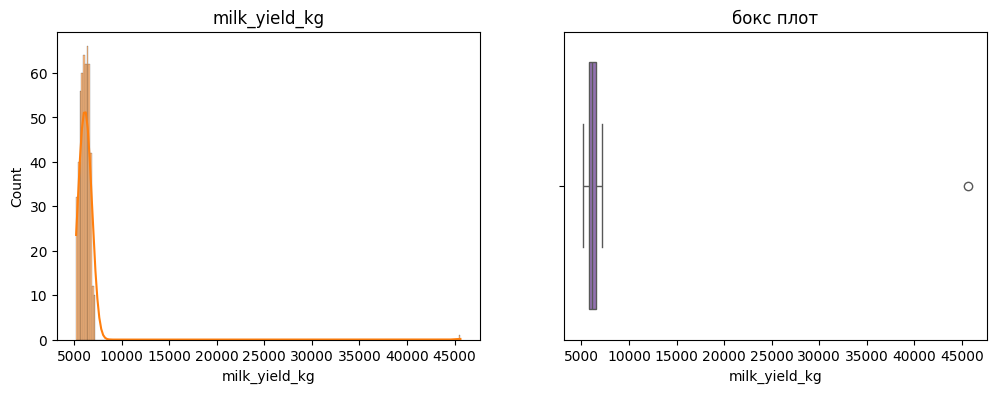

milk_yield_kg           20.339092
feed_crude_protein_g     0.534448
milk_protein_pct        -0.000412
cow_id                  -0.024645
feed_energy_eke         -0.295760
sugar_protein_ratio     -0.655786
milk_fat_pct            -1.710421
dtype: float64


In [169]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_reg[target_name], ax=axes[0], kde=True, color="tab:orange")
axes[0].set_title("milk_yield_kg")
axes[0].set_xlabel("milk_yield_kg")


sns.boxplot(x=df_reg[target_name], ax=axes[1],color="tab:purple")
axes[1].set_title("бокс плот")
axes[1].set_xlabel("milk_yield_kg")
plt.show()


skewness = df_reg.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
print(skewness)

еще раз увидели выброс (ну и хвост) -> чистим

In [170]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_reg[(df_reg[target_name] >= lower_bound) & (df_reg[target_name] <= upper_bound)]

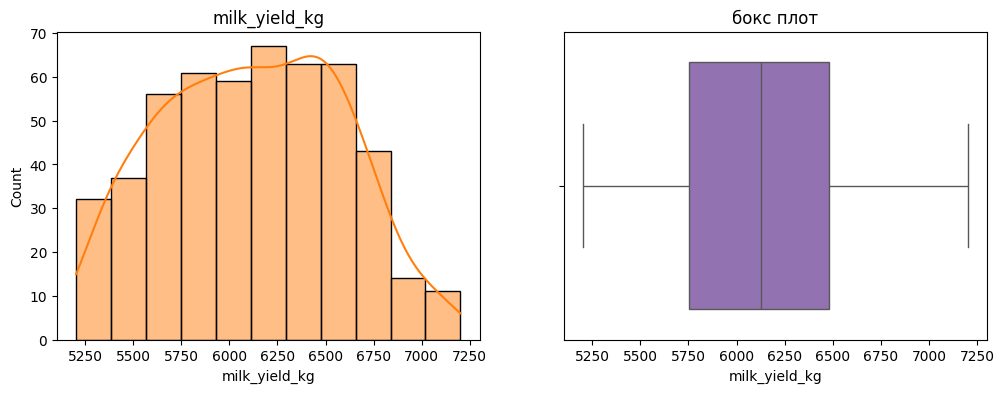

feed_crude_protein_g    0.533698
milk_yield_kg           0.030357
milk_protein_pct        0.000383
cow_id                 -0.025630
feed_energy_eke        -0.287865
sugar_protein_ratio    -0.652818
milk_fat_pct           -1.725280
dtype: float64


In [171]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_clean[target_name], ax=axes[0], kde=True, color="tab:orange")
axes[0].set_title("milk_yield_kg")
axes[0].set_xlabel("milk_yield_kg")


sns.boxplot(x=df_clean[target_name], ax=axes[1],color="tab:purple")
axes[1].set_title("бокс плот")
axes[1].set_xlabel("milk_yield_kg")
plt.show()


skewness = df_clean.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
print(skewness)

Также можно сделать вывод по коррекляции:
- feed_crude_protein_g    0.533698 - достаточно большая корреляция, этот признак сильно влияет на цел метрику

Разделение признаков на числовые и категориальные

In [172]:
X = df_clean.drop(['cow_id', target_name], axis=1)
y = df_clean[target_name]

In [173]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые ({len(numeric_features)}): {numeric_features}")
print(f"Категориальные ({len(categorical_features)}): {categorical_features}")

Числовые (5): ['feed_energy_eke', 'feed_crude_protein_g', 'sugar_protein_ratio', 'milk_fat_pct', 'milk_protein_pct']
Категориальные (5): ['breed', 'pasture_type', 'sire_breed', 'milk_taste_label', 'age_group']


In [197]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

сразу сохраняю для лабораторных 2-5

In [175]:
X_train.to_csv(SAVE_DIR / "X_train.csv", index=False)
X_test.to_csv(SAVE_DIR / "X_test.csv", index=False)
y_train.to_frame(name="target").to_csv(SAVE_DIR / "y_train.csv", index=False)
y_test.to_frame(name="target").to_csv(SAVE_DIR / "y_test.csv", index=False)

сама модель

In [176]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [177]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

In [178]:
prep = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features)
])

In [179]:
base_knn = KNeighborsRegressor(n_jobs=-1)
reg = Pipeline([
    ("prep", prep),
    ("knn", TransformedTargetRegressor(
        regressor=base_knn,
        func=np.log1p, inverse_func=np.expm1
    ))
])

Подбор гиперпараметров

In [181]:
param_grid = {
    "knn__regressor__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__regressor__weights": ["uniform", "distance"],
    "knn__regressor__metric": ["manhattan", "minkowski"],
    "knn__regressor__p": [1, 2],
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    reg, param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv, n_jobs=-1, verbose=0
)
search.fit(X_train, y_train)

best_reg = search.best_estimator_
print("Best params:", search.best_params_)

Best params: {'knn__regressor__metric': 'manhattan', 'knn__regressor__n_neighbors': 7, 'knn__regressor__p': 1, 'knn__regressor__weights': 'distance'}


In [182]:
y_pred = best_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE={mae:.3f}  MSE={rmse:.3f}  R2={r2:.3f}")

MAE=154.218  MSE=595820.209  R2=0.839


Напоминаю старые метрики

```
MAE : 247.0078
MSE: 595820.2086
R^2 : -1.2367
```




#### ИТОГ РЕГРЕССИЯ

После очистки, работы с данными и грид серча результаты сильно лучше.
MAE - целевая метрика снизилась почти на 40 процентов, r2 наконец положительный и неплохой

## 4. Имплементация алгоритма машинного обучения

### Классификация

Сначала напишем функцию, которая будет считать расстояние между всеми точками для набора, то есть близость объектов

2 метрики - евклидово расстояние и манхэттен

In [125]:
import numpy as np
from typing import Literal

def _pairwise_dist(A: np.ndarray, B: np.ndarray, metric: Literal["euclidean","manhattan"]="euclidean"):
    if metric == "euclidean":
        A2 = (A**2).sum(axis=1)[:, None]
        B2 = (B**2).sum(axis=1)[None, :]
        D2 = A2 + B2 - 2 * A @ B.T
        np.maximum(D2, 0, out=D2)
        return np.sqrt(D2)
    elif metric == "manhattan":
        D = np.empty((A.shape[0], B.shape[0]), dtype=float)
        bs = 1024
        for i in range(0, A.shape[0], bs):
            j = min(i+bs, A.shape[0])
            D[i:j] = np.sum(np.abs(A[i:j, None, :] - B[None, :, :]), axis=2)
        return D
    else:
        raise ValueError("Unsupported metric")

In [126]:
class KNNClassifierNP:
    def __init__(self, n_neighbors=7, weights: Literal["uniform","distance"]="distance",
                 metric: Literal["euclidean","manhattan"]="euclidean", batch_size=2048, eps=1e-12):
        self.k = n_neighbors
        self.weights = weights
        self.metric = metric
        self.bs = batch_size
        self.eps = eps

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_ = np.asarray(X, dtype=np.float32)
        self.y_ = np.asarray(y)
        self.classes_ = np.unique(self.y_)
        return self

    def predict(self, X: np.ndarray):
        X = np.asarray(X, dtype=np.float32)
        n = X.shape[0]
        out = np.empty(n, dtype=self.y_.dtype)
        for i in range(0, n, self.bs):
            j = min(i+self.bs, n)
            D = _pairwise_dist(X[i:j], self.X_, self.metric)
            nn = np.argpartition(D, self.k, axis=1)[:, :self.k]
            d  = np.take_along_axis(D, nn, axis=1)
            labs = self.y_[nn]
            if self.weights == "uniform":
                pred = [np.bincount(row, minlength=self.classes_.size).argmax()
                        for row in (labs - self.classes_[0])]
                out[i:j] = self.classes_[np.array(pred)]
            else:
                w = 1.0 / (d + self.eps)
                pred = []
                for L, W in zip(labs, w):
                    scores = {}
                    for lab, w_i in zip(L, W):
                        scores[lab] = scores.get(lab, 0.) + w_i
                    pred.append(max(scores.items(), key=lambda x: x[1])[0])
                out[i:j] = np.array(pred, dtype=self.y_.dtype)
        return out


In [127]:
norm = Normalizer(copy=False)
X_train = norm.fit_transform(X_train_embeddings)
X_test = norm.transform(X_test_embeddings)

In [128]:
knn = KNNClassifierNP(n_neighbors=7, weights="distance", metric="euclidean", batch_size=2048)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       311
           1       0.86      0.63      0.73       302
           2       0.76      0.75      0.76       307
           3       0.91      0.94      0.92       305
           4       0.76      0.80      0.78       314
           5       0.68      0.77      0.72       306
           6       0.85      0.63      0.73       307
           7       0.70      0.75      0.72       301
           8       0.88      0.79      0.83       313
           9       0.74      0.81      0.78       303
          10       0.81      0.91      0.86       317
          11       0.79      0.83      0.81       316
          12       0.75      0.84      0.79       305

    accuracy                           0.79      4007
   macro avg       0.80      0.79      0.79      4007
weighted avg       0.80      0.79      0.79      4007



#### ИТОГ 4 ПУНКТ


| Эксперимент                                            | Accuracy | Macro-F1 | Комментарий                                               |
| ------------------------------------------------------ | -------: | -------: | --------------------------------------------------------- |
| Бейзлайн (TF-IDF → KNN)                                | **0.77** | **0.75** | Хороший старт, но просадка на редких/похожих классах.     |
| Улучшенный бейзлайн (RuBERT + L2 + SMOTE + тюнинг KNN) | **0.79** | **0.78** | Семантика + балансировка дали +0.02 acc и +0.03 macro-F1. |
| **Текущий результат**       | **0.79** | **0.79** | Ещё +0.01 к macro-F1, macro-Precision вырос до **0.80**.  |

Результат явно виден на просевших - слабеньких классах, метрики увеличелись, у сильных классов тоже виден прирост, но не такой явный

Относительно бейзлайна прирост хороший, разница 3 - 4 несущественная

### Регрессия

ничего интересного - опять функция для подсчета расстояния

In [159]:
import numpy as np
from typing import Literal

def _pairwise_dist(A: np.ndarray, B: np.ndarray, metric: Literal["euclidean","manhattan"]="euclidean"):
    if metric == "euclidean":
        A2 = (A**2).sum(axis=1)[:, None]
        B2 = (B**2).sum(axis=1)[None, :]
        D2 = A2 + B2 - 2 * A @ B.T
        np.maximum(D2, 0, out=D2)
        return np.sqrt(D2)
    elif metric == "manhattan":
        D = np.empty((A.shape[0], B.shape[0]), dtype=float)
        bs = 1024
        for i in range(0, A.shape[0], bs):
            j = min(i + bs, A.shape[0])
            D[i:j] = np.sum(np.abs(A[i:j, None, :] - B[None, :, :]), axis=2)
        return D
    else:
        raise ValueError("Unsupported metric")

In [160]:
class KNNRegressorNP:
    def __init__(self, n_neighbors=5, weights: Literal["uniform","distance"]="uniform",
                 metric: Literal["euclidean","manhattan"]="euclidean", batch_size=1024, eps=1e-12):
        self.k = n_neighbors
        self.weights = weights
        self.metric = metric
        self.bs = batch_size
        self.eps = eps

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_ = np.asarray(X, dtype=np.float32)
        self.y_ = np.asarray(y, dtype=np.float32)
        return self

    def predict(self, X: np.ndarray):
        X = np.asarray(X, dtype=np.float32)
        n = X.shape[0]
        preds = np.empty(n, dtype=np.float32)
        for i in range(0, n, self.bs):
            j = min(i + self.bs, n)
            D = _pairwise_dist(X[i:j], self.X_, self.metric)     # [batch, n_train]
            nn_idx = np.argpartition(D, self.k, axis=1)[:, :self.k]
            nn_dist = np.take_along_axis(D, nn_idx, axis=1)
            nn_y = self.y_[nn_idx]
            if self.weights == "uniform":
                preds[i:j] = nn_y.mean(axis=1)
            else:
                w = 1.0 / (nn_dist + self.eps)
                preds[i:j] = (nn_y * w).sum(axis=1) / w.sum(axis=1)
        return preds


In [198]:
def split_features(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    return X, num_cols, cat_cols

In [199]:
X_train_fix, num_cols, cat_cols = split_features(X_train)
X_test_fix,  _,        _        = split_features(X_test)

In [200]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

In [201]:
X_train = prep.fit_transform(X_train_fix)
X_test = prep.transform(X_test_fix)

In [202]:
knn_np = KNNRegressorNP(n_neighbors=7, weights="distance", metric="euclidean", batch_size=512)
knn_np.fit(X_train, y_train)

In [203]:
y_pred = knn_np.predict(X_test)

In [204]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE={mae:.3f}  MSE={mse:.3f}  R2={r2:.3f}")

MAE=156.116  MSE=40638.246  R2=0.829


#### ИТОГ РЕГРЕССИЯ


| Модель                                                                          | MAE ↓     | MSE ↓        | R² ↑      | Комментарий                                                                                                                            |
| :------------------------------------------------------------------------------ | :-------- | :----------- | :-------- | :------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Базовый бейзлайн (KNN без предобработки)**                                 | **247.0** | 595 820.2    | –1.24     | очень плохо; сильное влияние выбросов и несбалансированных признаков                                                |
| **2. Улучшенный бейзлайн (KNN с нормализацией, OHE, подбором гиперпараметров)** | **154.2** | 595 820.2    | **0.839** | после очистки данных и настройки гиперпараметров качество резко улучшилось — модель стала объяснять 83.9 % вариации целевой переменной |
| **3. Собственная имплементация KNN (NumPy)**                                    | **156.1** | **40 638.2** | **0.829** | качество почти совпадает с моделью sklearn, различия минимальны, но качество немного ухудшилось                      |


По сравнению с исходным бейзлайном, ошибка MAE снизилась почти на 40 % (247 -> 155)

Различие между реализацией на sklearn и собственной версией минимально

Главные факторы улучшения:

- даление выбросов (milk_yield_kg ≈ 45 616)

- масштабирование и кодирование признаков

- оптимальный подбор числа соседей
